In [ ]:
# A dependency of the preprocessing for BERT inputs
# !pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
# !pip install -q tf-models-official==2.7.0

In [2]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 127 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=17840bf60d58b969f84866d045d32e345a224d50370b69ddcf89d2bab603c1af
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=1f8d573d1dd24d08fdc6c8237f1e796ccd916facc710100dd8b8c16f80cabbdc
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=28bb542fb91b0b5b5bff3c84d210429e5f9ba1ad451c7f6c7e9449b50af77f52
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [3]:
import os
import shutil
from google.colab import drive
import tensorflow as tf
import tensorflow_hub as hub
import re
import numpy as np
import bert
import random
import math
from tensorflow.keras import layers
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
import glob
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [37]:
#merging all female/male tweets in 1 csv

path=(r'/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/male/')

# path=(r'\content\gdrive\MyDrive\Spring2022\gender-detection\tweets\female')
# print(os.path.join(path , "*.csv"))
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

m_frame = pd.concat(li, axis=0, ignore_index=True)
#-------------------------------------------------------------------
path=(r'/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/female/')
f_files = glob.glob(os.path.join(path , "*.csv"))
li_f = []

for filename in f_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_f.append(df)

frame = pd.concat(li_f, axis=0, ignore_index=True)
frame

,twitter_id,date,tweet
0,1506744081510240268,2022-03-23 21:25:57+00:00,b'RT @etnow: .@4everBrandy is taking her actin...
1,1506358927524614153,2022-03-22 19:55:29+00:00,b'Get ready for the Best Christmas Ever! I\xe2...
2,1506350397212008449,2022-03-22 19:21:35+00:00,b'RT @strongblacklead: Best. Christmas. EVER.\...
3,1506339684259184651,2022-03-22 18:39:01+00:00,"b'RT @DEADLINE: EXCLUSIVE: Heather Graham, Bra..."
4,1504904220813762569,2022-03-18 19:35:00+00:00,b'@DisneyMusic @disneyplus This is beautiful! ...
...,...,...,...
13174,894627516895436800,2017-08-07 18:33:16+00:00,b'RT @SonyMusicGospel: .@alinebarros j\xc3\xa1...
13175,894529066019295233,2017-08-07 12:02:03+00:00,b'Comece a semana com uma linda palavra para o...
13176,894283223248900096,2017-08-06 19:45:10+00:00,b'Termino o domingo com essa mem\xc3\xb3ria li...
13177,894166365480906752,2017-08-06 12:00:48+00:00,b'A recompensa do justo \xc3\xa9 o tema da min...


In [41]:
#shuffling the dataframes
frame['label']='Female'
m_frame['label']='Male'
m_df = m_frame.sample(frac=1).reset_index(drop=True)
f_df = frame.sample(frac=1).reset_index(drop=True)
#seperating 10% of dataset for test
strt_m=int(0.1*len(m_df))
# strt_f=int(0.1*len(f_df))
test_f=f_df.tail(strt_m)
test_m=m_df.tail(strt_m)

#------------remove the test section from training data frame
frame.drop(frame.index[-1280:], inplace=True)
m_frame.drop(m_frame.index[-1280:], inplace=True)

# m_df

In [ ]:
test_m

In [ ]:
#merging 2 dataframes for test and training
#-------------test------------

test_li=[test_f, test_m]
test_df=pd.concat(test_li)
#shuffling the dataframe
result_test = test_df.sample(frac=1).reset_index(drop=True)
#-------------train------------

frames = [frame, m_frame]
result = pd.concat(frames)
#shuffling the dataframe
result_train = result.sample(frac=1).reset_index(drop=True)
result_train

In [ ]:
result_test

In [46]:
result_test.groupby(['label']).size()
result_train.groupby(['label']).size()


label
Female    11899
Male      11520
dtype: int64

In [47]:
#writing dataframes to csv files
result_test.to_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/test.csv') 
result_train.to_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train.csv') 


In [48]:
#reading the combined csv file
df = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/train.csv')
df.drop(['twitter_id','date','Unnamed: 0'], axis=1, inplace=True)
df

,tweet,label
0,b'RT @BetoORourke: Happy National Voter Regist...,Female
1,"b'RT @ForLife_ABC: At the end of the day, it\x...",Male
2,"b'What is this shit, I\xe2\x80\x99m trying to ...",Male
3,b'So much love and respect for this extremely ...,Female
4,b'You can still believe in doge coin and swing...,Male
...,...,...
23414,b'An Idaho lawmaker facing rape allegations fr...,Female
23415,b'RT @AlbeGeldenhuys: Excited to help @Mosaic_...,Male
23416,b'\xf0\x9f\x91\x80\xf0\x9f\x91\x80 @blkblockch...,Male
23417,b'RT @saribethrose: \xe2\x80\x9cPicking up the...,Female


In [49]:
#preprocessing

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [51]:
tweets = []
sentences = list(df['tweet'])
for sen in sentences:
    tweets.append(preprocess_text(sen))

In [52]:
# print(df.columns.values)
# df.label.unique()
y = df['label']
# changing labels to number values: Female = 1 , Male = 0
y = np.array(list(map(lambda x: 1 if x=="Female" else 0, y)))

In [53]:
print(tweets[1])
# print(y[10])

b RT ForLife ABC At the end of the day it xe x all about family xe d xa xef xb f Thanks for joining us for season of ForLife https co ugake ycMW 


In [54]:
#Bert Tokenizer
BertTokenizer = bert.bert_tokenization.FullTokenizer
#BERT embedding layer(not training it, frozen)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
#test tokenizer
# tokenizer.tokenize("b Get ready for the Best Christmas Ever xe x excited to join this phenomenal cast for this netflix holiday film xe xa xef xb f xf f e https co QOp jJc https co OkGKZg BMa")
#get the ids of tokens
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("b RT ForLife ABC At the end of the day it xe x all about family xe d xa xef xb f Thanks for joining us for season of ForLife https co ugake ycMW"))

In [59]:
def tokenize_tweets(text_tweets):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_tweets))

#tokenizing all tweets in dataset
tokenized_tweets = [tokenize_tweets(tweet) for tweet in tweets]

In [60]:
#getting the lenght of tweets along with tokens and label
tweets_with_len = [[tweet, y[i], len(tweet)]
                 for i, tweet in enumerate(tokenized_tweets)]

In [61]:
#shuffles the data randomly
random.shuffle(tweets_with_len)

In [62]:
#sort the data by the length of the tweets
tweets_with_len.sort(key=lambda x: x[2])

In [64]:
# tweets_with_len[10]

[[1038, 2188, 2051], 0, 3]

In [65]:
#remove lenght attribute
sorted_tweets_labels = [(tweet_lab[0], tweet_lab[1]) for tweet_lab in tweets_with_len]
#convert the sorted dataset into a TensorFlow 2.0-compliant input dataset shape
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_tweets_labels, output_types=(tf.int32, tf.int32))
#pad the tweets locally with respect to batche
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))


# Preparing test set

In [77]:
#pre processing test dataset
df_test = pd.read_csv('/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/test.csv')
df_test.drop(['twitter_id','date','Unnamed: 0'], axis=1, inplace=True)
test_tweets = []
test_sentences = list(df_test['tweet'])
for sen in test_sentences:
    test_tweets.append(preprocess_text(sen))
y_test = df_test['label']
# changing labels to number values: Female = 1 , Male = 0
y_test = np.array(list(map(lambda x: 1 if x=="Female" else 0, y_test)))

tokenized_test_tweets = [tokenize_tweets(tweet) for tweet in test_tweets]
#getting the lenght of tweets along with tokens and label
test_with_len = [[tweet, y[i], len(tweet)]
                 for i, tweet in enumerate(tokenized_test_tweets)]
#sort the data by the length of the tweets
test_with_len.sort(key=lambda x: x[2])
#remove lenght attribute
sorted_test = [(tweet_lab[0], tweet_lab[1]) for tweet_lab in test_with_len]
#convert the sorted dataset into a TensorFlow 2.0-compliant input dataset shape

processed_test = tf.data.Dataset.from_generator(lambda: sorted_test, output_types=(tf.int32, tf.int32))
test_set = processed_test.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))


In [ ]:
# next(iter(batched_dataset))

In [74]:
#dividing to train and validation

TOTAL_BATCHES = math.ceil(len(sorted_tweets_labels) / BATCH_SIZE)
#10% for valid
# TEST_BATCHES = TOTAL_BATCHES // 10
#15% for valid
TEST_BATCHES = int(0.15 * TOTAL_BATCHES)
batched_dataset.shuffle(TOTAL_BATCHES)
valid_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)


In [79]:
#Creating the Model
# consist of three convolutional neural network layers. You can use LSTM layers 
#instead and can also increase or decrease the number of layers. I have copied 
#the number and types of layers from SuperDataScience's Google colab notebook 
#and this architecture seems to work quite well for the IMDB Movie reviews
#(binary classifier) dataset as well

class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [80]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [81]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [82]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [83]:
history=text_model.fit(train_data, epochs=NB_EPOCHS, validation_data=valid_data)

Epoch 1/5
623/623 [==============================] - 43s 67ms/step - loss: 0.2102 - accuracy: 0.9097 - val_loss: 0.7449 - val_accuracy: 0.7328
Epoch 2/5
623/623 [==============================] - 42s 66ms/step - loss: 0.0698 - accuracy: 0.9730 - val_loss: 1.2284 - val_accuracy: 0.7050
Epoch 3/5
623/623 [==============================] - 41s 66ms/step - loss: 0.0218 - accuracy: 0.9928 - val_loss: 1.7389 - val_accuracy: 0.6757
Epoch 4/5
623/623 [==============================] - 45s 72ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 1.2400 - val_accuracy: 0.7506
Epoch 5/5
623/623 [==============================] - 45s 71ms/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 1.3961 - val_accuracy: 0.7431


In [84]:

results = text_model.evaluate(test_set)
print(results)

80/80 [==============================] - 1s 16ms/step - loss: 7.7910 - accuracy: 0.5016
[7.7910003662109375, 0.5015624761581421]


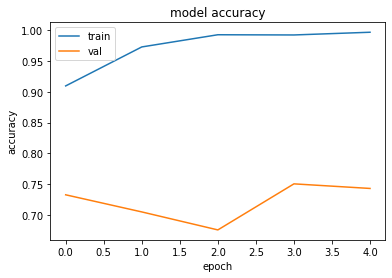

In [87]:
import keras
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

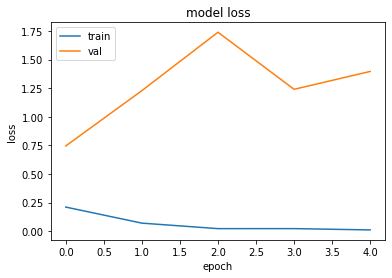

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
text_model.save("/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/cnn_1")

In [90]:
text_model.save_weights("/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/cnn_1_weights_chp")

In [91]:
text_model.save_weights("/content/gdrive/MyDrive/Spring2022/gender-detection/tweets/cnn_1_weights_h5", save_format="h5")